# Start LangGraph


In [1]:
import os
import re
import json
import yaml
import pandas as pd
import psycopg2
from openai import OpenAI
from dotenv import load_dotenv

# Setup Environment Variables

In [2]:
load_dotenv()

import os

OPENAI_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

os.environ["OPENAI_API_KEY"] = OPENAI_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY


# Build a Vector Database

In [3]:
# from langchain_openai import OpenAIEmbeddings
# openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [4]:
# from langchain_openai import OpenAIEmbeddings
# embed_model = OpenAIEmbeddings(model='text-embedding-3-small')


In [5]:
import os
import json
import numpy as np
import faiss
import pickle
from sentence_transformers import SentenceTransformer
from typing import List, Dict, Any, Tuple

In [6]:
chunks = None
index = None
embedding_model = None


In [7]:
def get_vector_store_and_retriever(resource_dir: str = "sec_embeddings") -> Tuple[List[Dict[str, Any]], faiss.Index, SentenceTransformer]:
    global chunks, index, embedding_model
    
    if chunks is not None and index is not None and embedding_model is not None:
        print("✅ Vector store & retriever already initialized. Reusing...")
        return chunks, index, embedding_model

    try:
        print(f"📁 Loading RAG vector store from: {resource_dir}")
        
        with open(os.path.join(resource_dir, "chunks.json"), 'r', encoding='utf-8') as f:
            chunks = json.load(f)
        
        with open(os.path.join(resource_dir, "embeddings.pkl"), 'rb') as f:
            embeddings = pickle.load(f)
        
        index = faiss.read_index(os.path.join(resource_dir, "faiss_index.bin"))
        embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
        
        print(f"✅ Loaded {len(chunks)} chunks into memory.")
        print("✅ FAISS index and SentenceTransformer initialized.")

    except Exception as e:
        print(f"❌ Failed to load vector store and retriever: {e}")
        chunks = None
        index = None
        embedding_model = None

    return chunks, index, embedding_model

## Create a Query Retrieval Grader

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document

# Tạo LLM với cấu hình Pydantic V2
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

# Parser
parser = StrOutputParser()

# Prompt system
SYS_PROMPT = """
You are an expert grader assessing whether a retrieved document contains relevant information to answer a user question.

Please follow these rules:
- Answer ONLY 'yes' or 'no'
- If the document contains a numeric value, table, or sentence that directly answers the question (even partially), say 'yes'
- Do NOT require exact match in wording; focus on meaning and key facts
- Ignore formatting or markdown

Be strict only when the document has no factual value for the question.
"""


# Tạo prompt template
grade_prompt = ChatPromptTemplate.from_messages([
    ("system", SYS_PROMPT),
    ("human", "Retrieved document:\n{document}\n\nUser question:\n{question}")
])

# Tạo chain xử lý
doc_grader = grade_prompt | llm | parser

# Build a QA RAG Chain

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If no context is present or if you don't know the answer, just say that you don't know the answer.
Do not make up the answer unless it is there in the provided context.
Give a detailed answer and to the point answer with regard to the question.
Question:
{question}
Context:
{context}
Answer:
"""
prompt_template = ChatPromptTemplate.from_template(prompt)

# Initialize connection with gpt-4.1-mini
chatgpt = ChatOpenAI(model_name='gpt-4.1-mini', temperature=0)

# Used for separating context docs with new lines
def format_docs(docs):
	return "\n\n".join(doc.page_content for doc in docs)

# Create QA RAG chain
qa_rag_chain = (
	{
		"context": (itemgetter('context')
					|
					RunnableLambda(format_docs)),
		"question": itemgetter('question')
	}
	|
	prompt_template
	|
	chatgpt
	|
	StrOutputParser()
)

# Create a Query Rephraser

In [10]:
# LLM for question rewriting
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
				 - Convert the following input question to a better version that is optimized for web search.
				 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
			 """
re_write_prompt = ChatPromptTemplate.from_messages(
	[
		("system", SYS_PROMPT),
		("human", """Here is the initial question:
					 {question}
					 Formulate an improved question.
				  """)
	]
)

# Create rephraser chain
question_rewriter = (re_write_prompt|llm|StrOutputParser())

# Load Web Search Tool

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults
tv_search = TavilySearchResults(max_results=3, search_depth='advanced', max_tokens=10000)

# SQL Query

In [12]:
load_dotenv()

DB_CONFIG = {
    "dbname": os.getenv("DBNAME") or os.getenv("POSTGRES_DB"),
    "user": os.getenv("DBUSER") or os.getenv("POSTGRES_USER"),
    "password": os.getenv("DBPASSWORD") or os.getenv("POSTGRES_PASSWORD"),
    "host": os.getenv("DBHOST") or "localhost",
    "port": int(os.getenv("DBPORT", 5432)),
    "sslmode": os.getenv("SSL_MODE", "require")
}


print(f"DB Config: {DB_CONFIG}")

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def connect_to_database():
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("Kết nối thành công đến PostgreSQL.")
        return conn
    except Exception as e:
        print(f"Lỗi kết nối cơ sở dữ liệu: {e}")
        return None

def get_schema_and_samples(conn):
    try:
        cursor = conn.cursor()
        cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='public';")
        tables = cursor.fetchall()
        schema_info = {}
        for (table,) in tables:
            cursor.execute(f"SELECT column_name, data_type FROM information_schema.columns WHERE table_name = '{table}';")
            schema_info[table] = [{"column_name": col, "data_type": dtype} for col, dtype in cursor.fetchall()]
            cursor.execute(f'SELECT * FROM "{table}" LIMIT 3;')
            sample_rows = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]
            schema_info[f"{table}_samples"] = [dict(zip(colnames, row)) for row in sample_rows]
        cursor.close()
        return schema_info
    except Exception as e:
        return {"error": str(e)}

def generate_sql_query(user_question, schema_info=None):
    prompt = f"""
You are a PostgreSQL expert. You are working with a financial database containing two structured tables: "djia_prices" and "djia_companies".

IMPORTANT:
- PostgreSQL is case-sensitive **only when using quoted identifiers**.
- You MUST wrap column names in double quotes (e.g. "Ticker", "Close", "Date").
- When comparing date values, always use `"Date"::date = 'YYYY-MM-DD'` to match correctly against date input.
- NEVER use `"Date" = 'YYYY-MM-DD'` because "Date" is stored as TIMESTAMPTZ.

Table 1: "djia_prices"
{{
"Date" (TIMESTAMPTZ),
"Open" (FLOAT),
"High" (FLOAT),
"Low" (FLOAT),
"Close" (FLOAT),
"Volume" (BIGINT),
"Dividends" (FLOAT),
"Stock_Splits" (FLOAT),
"Ticker" (VARCHAR)
}}

Table 2: "djia_companies"
{{
"symbol" (VARCHAR),
"name" (TEXT),
"sector" (TEXT),
"industry" (TEXT),
"country" (TEXT),
"market_cap" (FLOAT),
"pe_ratio" (FLOAT),
"dividend_yield" (FLOAT),
"description" (TEXT)
}}

Use this schema to write the most accurate and optimized PostgreSQL query to answer the following question.

IMPORTANT:
- DO NOT use subqueries on "djia_companies" to find the ticker by name.
- Instead, directly use the stock symbol (e.g. 'BA', 'AAPL', 'MSFT') when querying djia_prices.
- Assume the correct ticker will be matched externally by the system.

IMPORTANT:
- You MUST return only valid PostgreSQL SQL code.
- DO NOT include explanation, comments, markdown, or Python code.
- Return a single SQL query that can be executed directly.
- Do not say "this is a data science task".
- Assume the system will compute correlation and generate charts separately using Python.

IMPORTANT:
- Do NOT pivot data or return multiple tickers as columns.
- Always return raw data in long-form: one row per Ticker per Date.
- Required columns: "Date", "Ticker", "Close"
- The system will compute correlation separately.


Do NOT format the query in markdown. Return ONLY the raw SQL.

- If the user asks for market capitalization by sector as of a specific date (e.g. April 26, 2025), you should just use the static table "djia_companies".
- DO NOT use a subquery with "djia_prices" based on date.


User Question:
{user_question}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}]
        )
        sql_query = response.choices[0].message.content
        sql_query = re.sub(r'^```sql', '', sql_query).strip('` \n')
        return sql_query
    except Exception as e:
        print(f"❌ Lỗi sinh SQL: {e}")
        return None



def execute_sql_query(conn, query):
    try:
        df = pd.read_sql(query, conn)
        return df
    except Exception as e:
        print(f"❌ Lỗi thực thi SQL: {e}")
        return None

DB Config: {'dbname': 'postgres', 'user': 'postgres.qgoljxbwnlmvrutlylwp', 'password': 'WrWOSApFIXB2kI7E', 'host': 'aws-0-ap-southeast-1.pooler.supabase.com', 'port': 6543, 'sslmode': 'require'}


# Build Agentic RAG components

#### Graph State

In [13]:
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]
documents: List[str]

#### Retrieve function for retrieval from Vector DB

In [14]:
def retrieve(state):
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]
    documents = []

    chunks, index, model = get_vector_store_and_retriever(resource_dir="sec_embeddings")

    if index and chunks and model:
        try:
            # Encode query
            query_embedding = model.encode([question])[0].reshape(1, -1).astype(np.float32)

            # Search in the index
            distances, indices = index.search(query_embedding, 3)
            print(f"📌 Retrieved top {len(indices[0])} docs from FAISS")

            for i, idx in enumerate(indices[0]):
                if idx < len(chunks):
                    chunk = chunks[idx]
                    content = chunk["content"]
                    metadata = chunk.get("metadata", {})
                    score = float(1.0 / (1.0 + distances[0][i]))
                    doc = Document(page_content=content, metadata=metadata)
                    doc.metadata["score"] = score
                    documents.append(doc)
        except Exception as e:
            print(f"❌ Retrieval error: {e}")
    else:
        print("❌ No index/model/chunks available.")

    return {"documents": documents, "question": question}

#### Grade documents

In [15]:
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state.get("documents", [])

    filtered_docs = []

    if documents:
        for d in documents:
            # ✅ Nếu tài liệu là từ SQL → luôn cho qua
            if d.metadata.get("source") == "sql":
                print("✅ Bỏ qua grading (nguồn: SQL) → giữ lại")
                filtered_docs.append(d)
                continue

            # Còn lại thì dùng LLM grading
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.strip().lower()

            if grade == "yes":
                print("✅ GRADE: DOCUMENT RELEVANT")
                filtered_docs.append(d)
            else:
                print("❌ GRADE: DOCUMENT NOT RELEVANT")
    else:
        print("⚠️ Không có tài liệu nào để chấm điểm.")

    return {
        **state,
        "documents": filtered_docs
    }


#### Use SQL

In [16]:
from difflib import get_close_matches

DJIA_TICKERS = {
    "AAPL", "MSFT", "AMGN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS",
    "DOW", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD",
    "MMM", "MRK", "NKE", "PG", "TRV", "UNH", "V", "VZ", "WMT"
}


def map_company_name_to_ticker(question: str, mapping: dict) -> str | None:
    question_lower = question.lower()
    
    # Tìm tên công ty khớp gần nhất
    matched_names = get_close_matches(question_lower, mapping.keys(), n=1, cutoff=0.4)

    if matched_names:
        matched = matched_names[0]
        print(f"✅ Gần đúng: '{matched}' → {mapping[matched]}")
        return mapping[matched]

    # Nếu không khớp fuzzy, fallback về in-string match
    for name, ticker in mapping.items():
        if name in question_lower:
            print(f"✅ Ánh xạ trực tiếp: '{name}' → {ticker}")
            return ticker

    print("⚠️ Không ánh xạ được công ty nào.")
    return None
def get_name_to_ticker_mapping(conn):
    cursor = conn.cursor()
    cursor.execute('SELECT name, symbol FROM djia_companies')
    result = cursor.fetchall()
    cursor.close()

    # Chuẩn hóa name về lowercase và bỏ từ dư (Inc., Corp., Company,...)
    clean_mapping = {}
    for name, symbol in result:
        name_clean = name.lower().replace("inc.", "").replace("corporation", "").replace("company", "").replace("(the)", "").strip()
        clean_mapping[name_clean] = symbol

    return clean_mapping

def extract_tickers_from_question(question: str, conn=None) -> list:
    question_upper = question.upper()

    # ✅ Tách câu thành các từ viết hoa (loại bỏ dấu câu)
    tokens = set(re.findall(r'\b[A-Z]{2,5}\b', question_upper))

    # ✅ So khớp với DJIA_TICKERS
    tickers = [token for token in tokens if token in DJIA_TICKERS]

    # ✅ Kết hợp ánh xạ tên công ty nếu có DB
    if conn:
        mapping = get_name_to_ticker_mapping(conn)
        question_lower = question.lower()

        matched_names = get_close_matches(question_lower, mapping.keys(), n=5, cutoff=0.4)
        for name in matched_names:
            ticker = mapping[name]
            if ticker not in tickers:
                tickers.append(ticker)

        for name, ticker in mapping.items():
            if name in question_lower and ticker not in tickers:
                tickers.append(ticker)

    print(f"✅ Ticker(s) detected: {tickers}")
    return tickers


In [17]:
question = "Plot a heatmap of the correlation matrix of daily returns in 2024 for AAPL, MSFT, JPM, BA, and WMT"
# question = "Create a boxplot of monthly closing prices of Walt Disney (DIS) for each month of 2024."
# question = "Create a boxplot of monthly closing prices of DIS for each month of 2024."

conn = connect_to_database()
if conn:
    ticker = extract_tickers_from_question(question, conn)
    print(f"➡️ Mã cổ phiếu ánh xạ được: {ticker}")
    conn.close()


Kết nối thành công đến PostgreSQL.
✅ Ticker(s) detected: ['MSFT', 'BA', 'JPM', 'WMT', 'AAPL']
➡️ Mã cổ phiếu ánh xạ được: ['MSFT', 'BA', 'JPM', 'WMT', 'AAPL']


In [18]:
import pandas as pd
from langchain.schema import Document
from finance_metrics import load_formulas, identify_metric, get_required_fields, compute_metric
from plot_metric import plot_chart
import re

def extract_rolling_window(question: str, default: int = 30) -> int:
    match = re.search(r"(\d+)[- ]day rolling average", question.lower())
    if match:
        return int(match.group(1))
    return default


def detect_chart_type(question: str):
    q = question.lower()

    if "scatter" in q or "scatter plot" in q:
        return "scatter"
    if "bar chart" in q or "barplot" in q or "bar plot" in q:
        return "bar"
    if "pie chart" in q or "pie" in q:
        return "pie"
    if "boxplot" in q or "box plot" in q:
        return "box"
    if "histogram" in q or "hist" in q:
        return "hist"
    if "heatmap" in q or "correlation matrix" in q:
        return "heatmap"
    if "time series" in q or "plot the closing price" in q or "line chart" in q or "time-series" in q:
        return "line"
    if "rolling average" in q or "moving average" in q:
        return "line_ma"
    if "cumulative return" in q:
        return "cumulative"
    if "dividend" in q:
        return "dividend"
    if "high-low range" in q or "daily range" in q:
        return "range"

    return None



def query_sql(state):
    print("---EXECUTE RAW SQL QUERY OR METRIC COMPUTATION---")
    question = state["question"]

    # Bước 1: Kết nối DB
    conn = connect_to_database()
    if conn is None:
        raise ValueError("❌ Không thể kết nối cơ sở dữ liệu.")

    # Bước 2: Trích xuất schema + sample để đưa vào prompt LLM
    schema_info = get_schema_and_samples(conn)

    # Bước 3: Dùng LLM sinh SQL truy vấn
    sql_query = generate_sql_query(question, schema_info)
    if not sql_query:
        conn.close()
        raise ValueError("❌ Không thể sinh truy vấn SQL từ câu hỏi.")

    print(f"🧠 Generated SQL Query:\n{sql_query}")

    # Bước 4: Thực thi SQL
    df = execute_sql_query(conn, sql_query)
    conn.close()

    # Bước 5: Nếu không có kết quả → fallback sang web
    if df is None or df.empty:
        print("⚠️ SQL trả về rỗng. Cần dùng web search.")
        return {
            "documents": state["documents"],
            "question": question,
            "sql_query": sql_query,
            "web_search_needed": "Yes"
        }

    # Bước 6: Nếu câu hỏi yêu cầu biểu đồ
    chart_type = detect_chart_type(question)
    if chart_type:
        print(f"📊 Detected chart type: {chart_type}")

        # Process separately for the heatmap chart
        if chart_type == "heatmap":
            print("📊 Detected heatmap request — building correlation matrix.")

            conn = connect_to_database()
            tickers = extract_tickers_from_question(question, conn)
            if not tickers:
                conn.close()
                return {
                    **state,
                    "generation": "⚠️ Không tìm thấy mã cổ phiếu trong câu hỏi để vẽ heatmap."
                }

            tickers_str = "', '".join(tickers)
            sql_query = f"""
                SELECT "Date", "Ticker", "Close"
                FROM "djia_prices"
                WHERE "Date"::date BETWEEN '2024-01-01' AND '2024-12-31'
                AND "Ticker" IN ('{tickers_str}')
                ORDER BY "Date"
            """

            print(f"🧠 SQL Query for heatmap:\n{sql_query}")
            df = pd.read_sql(sql_query, conn)
            conn.close()

            if df.empty:
                return {
                    **state,
                    "generation": "⚠️ Không có dữ liệu cho các mã cổ phiếu trong năm 2024."
                }

            # Chuẩn hóa returns theo từng ticker
            df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce")
            df = df.dropna(subset=["Date", "Close", "Ticker"])

            # Pivot: mỗi ticker là 1 cột, mỗi hàng là 1 ngày
            pivot_df = df.pivot(index="Date", columns="Ticker", values="Close")
            returns_df = pivot_df.pct_change().dropna()

            if returns_df.shape[1] < 2:
                return {
                    **state,
                    "generation": "⚠️ Không đủ mã cổ phiếu có dữ liệu để tính tương quan."
                }

            # Vẽ heatmap từ returns
            image_base64 = plot_chart(returns_df, "heatmap", question)

            result_doc = Document(
                page_content="📊 Correlation heatmap of daily returns generated below.",
                metadata={"image_base64": image_base64, "source": "sql"}
            )

            return {
                "documents": state["documents"] + [result_doc],
                "question": question,
                "sql_query": sql_query,
                "web_search_needed": "No"
            }




        
        if chart_type == "line_ma":
            window = extract_rolling_window(question)
            ma_col = f"MA_{window}"
            df["Date"] = pd.to_datetime(df["Date"], utc=True)
            df[ma_col] = df["Close"].rolling(window=window).mean()
            df_chart = df[["Date", "Close", ma_col]]

            image_base64 = plot_chart(df_chart, chart_type, question)

            result_doc = Document(
                page_content=f"📊 Chart generated: {chart_type}",
                metadata={"image_base64": image_base64, "source": "sql"}
            )

            return {
                "documents": state["documents"] + [result_doc],
                "question": question,
                "sql_query": sql_query,
                "web_search_needed": "No"
            }



        if df is not None and not df.empty:
            df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce")
            df = df.dropna(subset=["Date"])
            
            image_base64 = plot_chart(df, chart_type, question)

            if image_base64:
                result_doc = Document(
                    page_content=f"📊 The requested chart has been generated below.",
                    metadata={"image_base64": image_base64, "source": "sql"}
                )
            else:
                result_doc = Document(
                    page_content=f"⚠️ Failed to generate chart.",
                    metadata={"source": "sql"}
                )
            return {
                "documents": state["documents"] + [result_doc],
                "question": question,
                "sql_query": sql_query,
                "web_search_needed": "No"
            }
        else:
            result_doc = Document(
                page_content="⚠️ No data available for charting.",
                metadata={"source": "sql"}
            )

    else:
        # Nếu không phải câu hỏi yêu cầu biểu đồ → trả kết quả dạng bảng
        result_doc = Document(
            page_content=f"📊 SQL Query Result:\n\n{df.to_markdown(index=False)}",
            metadata={"source": "sql"}
        )

    # Trả kết quả về state
    return {
        "documents": state["documents"] + [result_doc],
        "question": question,
        "sql_query": sql_query,
        "web_search_needed": "No"
    }



### Assess combined documents

In [19]:
def assess_combined_documents(state):
    print("---REASSESS COMBINED DOCUMENTS---")

    question = state.get("question", "")
    all_docs = state.get("documents", [])

    reassessed_docs = []

    for doc in all_docs:
        score = doc_grader.invoke({"question": question, "document": doc.page_content}).strip().lower()
        if score == "yes":
            print("✅ Reassessed: Relevant")
            reassessed_docs.append(doc)
        else:
            print("❌ Reassessed: Not relevant")

    print(f"🔍 Number of relevant documents after reassessment: {len(reassessed_docs)}")

    return {
        **state,
        "documents": reassessed_docs
    }


#### Decide after reassessment

In [20]:
def decide_after_reassessment(state):
    docs = state.get("documents", [])
    num_docs = len(docs)
    print(f"🔍 Number of relevant documents after reassessment: {num_docs}")

    if num_docs >= 1:
        print("✅ Enough relevant documents found → proceed to generate_answer")
        return "generate_answer"
    else:
        print("⚠️ Not enough relevant documents → fallback to rewrite_query")
        return "rewrite_query"


#### Rewrite query

In [21]:
def rewrite_query(state):
    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

#### Decide web search or generate answer

In [22]:
def decide_after_sql(state):
    if state.get("web_search_needed", "No") == "Yes":
        print("---DECISION: Missing SQL data → web search---")
        return "rewrite_query"
    
    print("---DECISION: Sufficient SQL data → generate answer---")
    return "generate_answer"


#### Web search

In [23]:
from langchain_core.documents import Document  # dùng đúng version core

def web_search(state):
    """
    Perform web search based on the rewritten question and return a unified Document.
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    try:
        docs = tv_search.invoke(question)

        if not docs:
            print("⚠️ No results returned from web search.")
            return {"documents": documents, "question": question}

        print("📥 Web search results received.")
        print("DOCS TYPE:", type(docs))
        print("FIRST ELEMENT TYPE:", type(docs[0]) if docs else "EMPTY")

        # Format content
        if isinstance(docs[0], str):
            web_content = "\n\n".join(docs)
        elif isinstance(docs[0], dict) and "content" in docs[0]:
            web_content = "\n\n".join([d["content"] for d in docs])
        elif isinstance(docs[0], Document):
            web_content = "\n\n".join([d.page_content for d in docs])
        else:
            raise TypeError(f"Unsupported document format: {type(docs[0])}")

        # Append web search result as 1 Document
        web_results = Document(
            page_content=web_content,
            metadata={"source": "web_search"}
        )

        documents.append(web_results)
        print("✅ Web search content appended to documents.")
        return {"documents": documents, "question": question}

    except Exception as e:
        print(f"❌ Error during web search: {str(e)}")
        return {"documents": documents, "question": question}


#### Generate Answer

In [24]:
def generate_answer(state):
    print("---GENERATE ANSWER---")

    question = state.get("question", "")
    documents = state.get("documents", [])

    if not question:
        print("⚠️ No question provided.")
        return {**state, "generation": "No question was given."}

    if not documents:
        print("⚠️ No documents available for context.")
        return {**state, "generation": "I don't have enough context to answer the question."}

    try:
        # ✅ Nếu có tài liệu chứa ảnh (image_base64) → hiển thị ngay, không gọi LLM
        for doc in documents:
            if isinstance(doc, Document) and doc.metadata.get("image_base64"):
                print("✅ Found image in document → skipping LLM")
                return {
                    **state,
                    "generation": "📊 The requested chart has been generated below.",
                    "image_base64": doc.metadata["image_base64"]
                }

        # ❗ Nếu không có ảnh → fallback sang LLM
        generation = qa_rag_chain.invoke({
            "context": documents,
            "question": question
        })

        print("✅ Answer generated from LLM.")
        return {
            **state,
            "generation": generation
        }

    except Exception as e:
        print(f"❌ Error during answer generation: {str(e)}")
        return {
            **state,
            "generation": f"Error generating answer: {str(e)}"
        }


# Build the Agent Graph with LangGraph

In [25]:
from langgraph.graph import StateGraph, END

# === Build Agentic RAG: vector → SQL → (chart or reassess) → answer/web ===
agentic_rag = StateGraph(GraphState)

# Add nodes
agentic_rag.add_node("retrieve", retrieve)
agentic_rag.add_node("grade_documents", grade_documents)
agentic_rag.add_node("query_sql", query_sql)
agentic_rag.add_node("assess_combined_documents", assess_combined_documents)
agentic_rag.add_node("rewrite_query", rewrite_query)
agentic_rag.add_node("web_search", web_search)
agentic_rag.add_node("generate_answer", generate_answer)

# Entry point
agentic_rag.set_entry_point("retrieve")

# Flow: retrieve → grade_documents
agentic_rag.add_edge("retrieve", "grade_documents")

# Nếu có docs → generate_answer, nếu không → query_sql
agentic_rag.add_conditional_edges(
    "grade_documents",
    lambda state: "generate_answer" if len(state.get("documents", [])) >= 1 else "query_sql",
    {
        "generate_answer": "generate_answer",
        "query_sql": "query_sql"
    }
)

# ✅ THAY ĐỔI Ở ĐÂY: phân nhánh sau query_sql dựa trên biểu đồ/web search
def decide_after_query_sql(state):
    question = state.get("question", "")
    if detect_chart_type(question):
        print("---DECISION: This is a charting question → generate_answer")
        return "generate_answer"
    elif state.get("web_search_needed", "No") == "Yes":
        print("---DECISION: SQL failed → fallback to rewrite_query")
        return "rewrite_query"
    else:
        print("---DECISION: Proceed to reassess documents")
        return "assess_combined_documents"

agentic_rag.add_conditional_edges(
    "query_sql",
    decide_after_query_sql,
    {
        "generate_answer": "generate_answer",
        "rewrite_query": "rewrite_query",
        "assess_combined_documents": "assess_combined_documents"
    }
)

# Flow tiếp theo từ reassess
agentic_rag.add_conditional_edges(
    "assess_combined_documents",
    decide_after_reassessment,  # return "generate_answer" or "rewrite_query"
    {
        "generate_answer": "generate_answer",
        "rewrite_query": "rewrite_query"
    }
)

# Web search → generate answer
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")

# End
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()


In [26]:
print(type(agentic_rag))

<class 'langgraph.graph.state.CompiledStateGraph'>


In [27]:
# from IPython.display import Image, display, Markdown
# display(Image(agentic_rag.get_graph().draw_mermaid_png()))

# Test Agentic RAG System

In [28]:
from IPython.display import Markdown, display
from IPython.display import Image as IPImage

In [29]:
from PIL import Image
import base64

def show_result(response):
    display(Markdown(response.get("generation", "")))
    for doc in response.get("documents", []):
        if isinstance(doc, Document) and "image_base64" in doc.metadata:
            img_data = base64.b64decode(doc.metadata["image_base64"])
            display(IPImage(data=img_data))


In [30]:
# query = "What was the highest price Apple reached on February 28, 2025?"
# response = agentic_rag.invoke({"question": query})
# display(Markdown(response['generation']))
# show_result(response)

In [31]:
# query = "Plot the time series of Microsoft (MSFT) stock closing price from June 1, 2024 to September 30, 2024."
# response = agentic_rag.invoke({"question": query})
# display(Markdown(response['generation']))
# show_result(response)

In [32]:
# query = "What was the opening price of Boeing on August 1, 2023?"
# response = agentic_rag.invoke({"question": query})
# display(Markdown(response['generation']))
# show_result(response)

In [33]:
# query = "Create a bar chart of Caterpillar (CAT) average monthly closing price in 2024"
# response = agentic_rag.invoke({"question": query})
# display(Markdown(response['generation']))
# show_result(response)

In [34]:
# query = "Create a pie chart of market capitalization proportions by sector as of April 26, 2025"
# response = agentic_rag.invoke({"question": query})
# display(Markdown(response['generation']))
# show_result(response)

---RETRIEVAL FROM VECTOR DB---
📁 Loading RAG vector store from: sec_embeddings


✅ Loaded 89 chunks into memory.
✅ FAISS index and SentenceTransformer initialized.
📌 Retrieved top 3 docs from FAISS
---CHECK DOCUMENT RELEVANCE TO QUESTION---
❌ GRADE: DOCUMENT NOT RELEVANT
❌ GRADE: DOCUMENT NOT RELEVANT
❌ GRADE: DOCUMENT NOT RELEVANT
---EXECUTE RAW SQL QUERY OR METRIC COMPUTATION---
Kết nối thành công đến PostgreSQL.
🧠 Generated SQL Query:
SELECT 
    "Date", 
    "Ticker", 
    ("Close" - LAG("Close", 1) OVER (ORDER BY "Date")) / LAG("Close", 1) OVER (ORDER BY "Date") AS "Daily_Return"
FROM 
    "djia_prices"
WHERE 
    "Ticker" = 'AAPL' AND
    "Date"::date >= '2024-01-01' AND 
    "Date"::date <= '2024-12-31'


C:\Users\trung\AppData\Local\Temp\ipykernel_20452\3623657544.py:127: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📊 Detected chart type: box
---DECISION: This is a charting question → generate_answer
---GENERATE ANSWER---
✅ Found image in document → skipping LLM


📊 The requested chart has been generated below.

📊 The requested chart has been generated below.

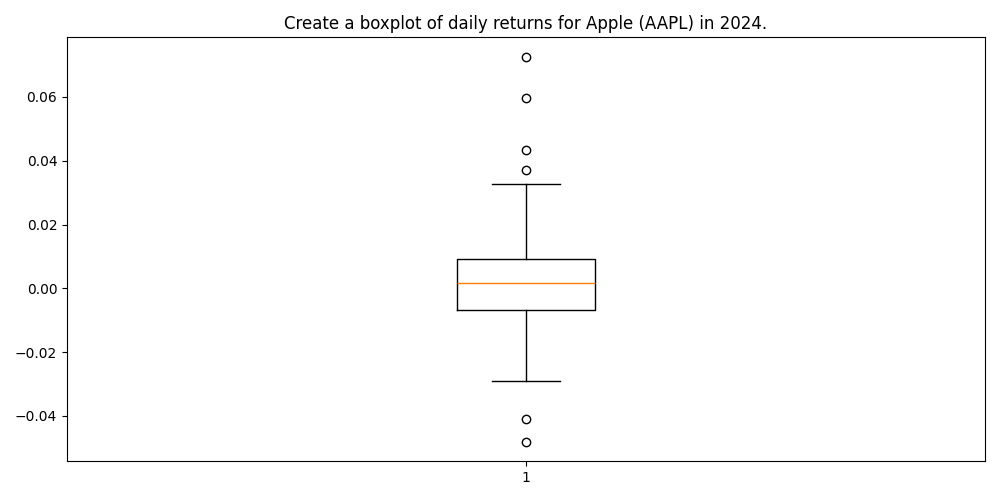

In [35]:
query = "Create a boxplot of daily returns for Apple (AAPL) in 2024."
response = agentic_rag.invoke({"question": query})
display(Markdown(response['generation']))
show_result(response)

In [36]:
# query = "Plot the cumulative return of UnitedHealth Group (UNH) during 2024."
# response = agentic_rag.invoke({"question": query})
# display(Markdown(response['generation']))
# show_result(response)

In [37]:
# query = " Plot a heatmap of the correlation matrix of daily returns in 2024 for AAPL, MSFT, JPM, BA, and WMT."
# response = agentic_rag.invoke({"question": query})
# display(Markdown(response['generation']))
# show_result(response)

In [38]:
# query = "Plot Microsoft (MSFT) daily closing price and its 30-day rolling average during 2024"
# response = agentic_rag.invoke({"question": query})
# display(Markdown(response['generation']))
# show_result(response)